# Clustering

In [1]:
import warnings, platform
from IPython.display import display, HTML

In [2]:
### HTML display 조정
display(HTML("<style>.container {width :98% !important;}</style>"))

### Warning 제거
warnings.filterwarnings('ignore')

## Package load

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [4]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.datasets import fetch_openml

from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles

## Distance Metrics
- Clustering의 기준이 되는 지표들
- Numeric
    - 수학적: Euclidian(제곱), Manhattan(절대값), Chebyshev(각 dimension의 Manhattan 거리 중 최대값), Minkowski(n제곱), Canberra(가중 절대값), Cosine(벡터 방향각)
    - 통계적: Standardized(표본분산), Mahalanobis(표본 공분산)
- Categorical
    - Dice (2*교집합/A + B 영역), Jaccard(교집합/합집합 영역), Hamming (같은 위치에서, 서로 다른 원소의 개수)
- Mixed: Gower

In [5]:
from scipy.spatial import distance

### (1) Numeric

In [6]:
a = np.array((1, 2, 3, 4))
b = np.array((1, 1, 1, 3))

In [7]:
### Euclidian
distance.euclidean(a, b)

2.449489742783178

In [8]:
### Manhattan
distance.cityblock(a, b)

4

In [9]:
### Chebyshev
distance.chebyshev(a, b)

2

In [10]:
### Canberra
distance.canberra(a, b)

0.976190476190476

In [11]:
### Minkowski
distance.minkowski(a, b)

2.449489742783178

In [12]:
### Cosine
distance.cosine(a, b)

0.05131670194948623

In [13]:
### Correlation
# 1 - pd.DataFrame([a, b]).T.corr()[1][0]
# 선형 관계 correlation의 역수
distance.correlation(a, b)

0.2254033307585166

In [14]:
### Standardized
iv = [[0.5, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0.5, 0], [0, 0, 0, 1]] # inverse of sample variance(diag) matrix
distance.mahalanobis(a, b, iv)

2.0

In [15]:
### Mahalanobis
iv = [[1, 0.5, 0.5, 1], [0.5, 1, 0.5, 1], [0.5, 0.5, 1, 1], [1, 1, 1, 1]] # inverse of cov matrix
distance.mahalanobis(a, b, iv)

3.7416573867739413

### (2) Categorical

In [16]:
a = np.array((1, 0, 1, 1, 1))
b = np.array((1, 0, 0, 0, 1))

In [17]:
### Dice
distance.dice(a, b)

0.3333333333333333

In [18]:
### Jaccard
distance.jaccard(a, b)

0.5

In [19]:
### Hamming
distance.hamming(a, b)

0.4

### (3) Oridinal

In [20]:
a = np.array((1, 2, 3, 4))
b = np.array((1, 3, 4, 8))

In [21]:
### Rank Correlation distance
# Spearman 상관계수의 역수
1 - pd.DataFrame([a, b]).T.corr(method='spearman')[1][0]

0.0

### (4) Mixed
- Gower: 수치형+범주형 모든 변수가 0-1 사이에 오도록 함
    - 수치형은 Manhattan, 범주형은 다르면 1, 같으면 0

In [22]:
# !pip install gower
import gower

In [23]:
loan_data = pd.read_csv("./Practical_Statictics/data/loan_data.csv.gz")
defaults = loan_data.loc[loan_data['outcome']=='default', ]

x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]

In [24]:
gower.gower_matrix(x)

array([[0.        , 0.62204784, 0.6863877 , 0.632904  , 0.37727892],
       [0.62204784, 0.        , 0.8143398 , 0.7608561 , 0.5389727 ],
       [0.6863877 , 0.8143398 , 0.        , 0.43070832, 0.30910876],
       [0.632904  , 0.7608561 , 0.43070832, 0.        , 0.505625  ],
       [0.37727892, 0.5389727 , 0.30910876, 0.505625  , 0.        ]],
      dtype=float32)

## Hierarchical Clustering
- 개체(군집) 간 거리(유사성) 기반 분석

### (1) Agglomerative Clustering
- 연결법
    - 최단, 최장, 평균: 지역적 최적화
    - 중심, 와드: 군집의 크기에 가중을 둘 수 있음
- methods: single, complete, average, weighted, centroid, median, ward

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [26]:
usarrests = pd.read_csv('./r_csv/datasets/USArrests.csv', index_col='Unnamed: 0')
usarrests.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [27]:
label_list = usarrests.index

#### Single Linkage Method
- 최단연결법
- 군집 별 관측치 거리의 최소값으로 거리 측정
- 군집의 객체 수가 비슷하지 않을 수 있음

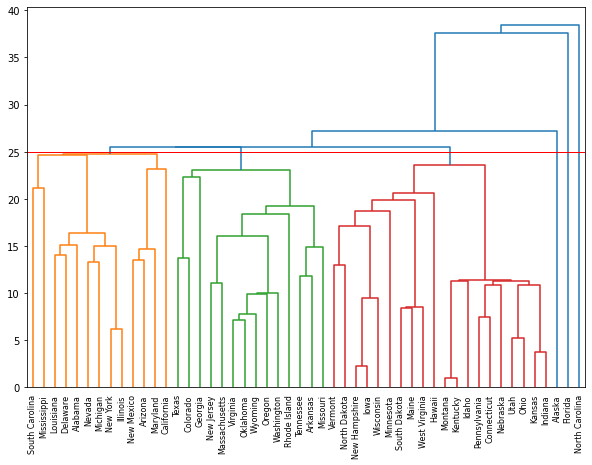

In [28]:
single = linkage(usarrests.iloc[:, 1::], metric='euclidean', method='single')

# 덴드로그램 그리기
plt.figure(figsize=(10, 7))
dendrogram(single,
            orientation='top',
            labels=label_list,
            distance_sort='descending',
            color_threshold=25,# 군집의 수를 설정하는 Height 값 설정
            show_leaf_counts=True)

plt.axhline(y=25, color='r', linewidth=1) # Height 값에 따라 선을 그어 적절한 군집 수 설정
plt.show()

#### Ward Linkage Method
- 최단연결법의 단점 보완. 군집 내 오차(SSE)에 기반한 거리 측정
- 상대적으로 계산량이 많으나, 해석력이 높음

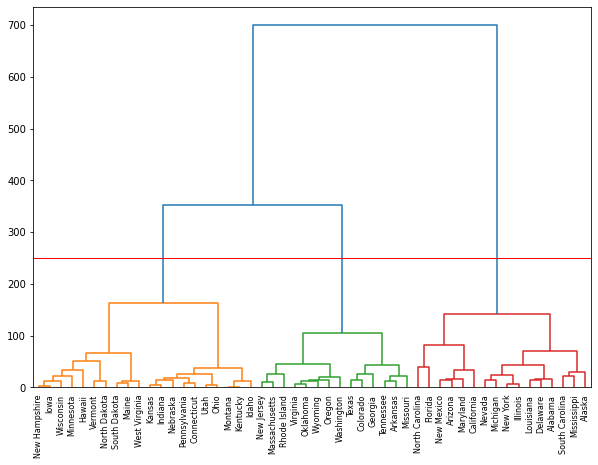

In [29]:
ward = linkage(usarrests.iloc[:, 1::], metric='euclidean', method='ward')

# 덴드로그램 그리기
plt.figure(figsize=(10, 7))
dendrogram(ward,
            orientation='top',
            labels=label_list,
            distance_sort='descending',
            color_threshold=250,
            show_leaf_counts=True)
plt.axhline(y=250, color='r', linewidth=1)  # Height 값에 따라 선을 그어 적절한 군집 수 설정
plt.show()


In [30]:
# state마다 어떤 군집에 설정되었는지 확인
assignments = fcluster(ward, 250, 'distance')
assignments

array([1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 2, 1,
       3, 1, 2, 3, 3, 1, 3, 2, 1, 1, 1, 3, 3, 2, 2, 3, 2, 1, 3, 2, 2, 3,
       3, 2, 2, 3, 3, 2], dtype=int32)

In [31]:
usarrests['cluster'] = assignments
usarrests.groupby('cluster').mean()

,Murder,Assault,UrbanPop,Rape
cluster,,,,
1,11.812500,272.562500,68.312500,28.375000
2,8.214286,173.285714,70.642857,22.842857
3,4.270000,87.550000,59.750000,14.390000


#### Complete Linkage Method
- Scikit-learn 사용했으나, Scipy 사용도 위와 마찬가지로 가능

In [32]:
from sklearn.cluster import AgglomerativeClustering

In [33]:
import numpy as np

In [34]:
### Agglomerative with Scikit-learn
x = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(x)

In [35]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [36]:
agg.labels_

array([1, 1, 0, 0])

In [37]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

#### Average Linkage Method & Gower distance

In [38]:
import gower

In [39]:
x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]
x

,dti,payment_inc_ratio,home_,purpose_
0,1.00,2.39320,RENT,major_purchase
1,5.55,4.57170,OWN,small_business
2,18.08,9.71600,RENT,other
3,10.08,12.21520,RENT,debt_consolidation
4,7.06,3.90888,RENT,other


In [40]:
dist_matrix = gower.gower_matrix(x)
model_average = AgglomerativeClustering(n_clusters=2, linkage='average', affinity='precomputed')
clusters_average = model_average.fit_predict(dist_matrix)
clusters_average

array([0, 1, 0, 0, 0])

### (2) HDBSCAN
- Hierachical DBSCAN
- 계층적 구조 및 Local density에 대한 정보 반영
- HDBDCAN Steps
    - Transform the space according to the density/sparsity.
    - Build the minimum spanning tree of the distance weighted graph.
    - Construct a cluster hierarchy of connected components.
    - Condense the cluster hierarchy based on minimum cluster size.
    - Extract the stable clusters from the condensed tree.

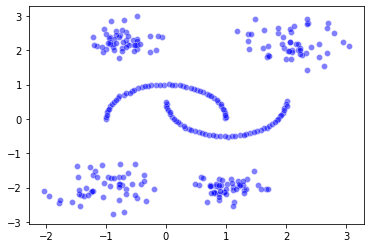

In [41]:
num = 100
moons, _ = make_moons(n_samples=num, noise=0.01)
blobs, _ = make_blobs(n_samples=num, centers=[(-0.75,2.25), (1.0, -2.0)], cluster_std=0.25)
blobs2, _ = make_blobs(n_samples=num, centers=[(2,2.25), (-1, -2.0)], cluster_std=0.4)
test_data = np.vstack([moons, blobs,blobs2])
sns.scatterplot(test_data.T[0], test_data.T[1], color='blue', alpha=0.5, linewidths=0)
plt.show()

In [42]:
# !pip install hdbscan
import hdbscan

In [43]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True) # min_size는 없을 경우 min_cluster_size로 자동 생성
clusterer.fit(test_data)

HDBSCAN(gen_min_span_tree=True)

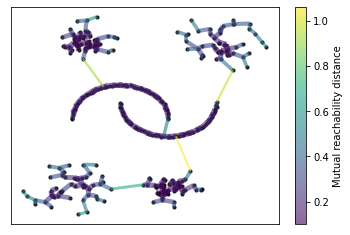

In [44]:
# Cluster hierachy tree 
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=10, edge_linewidth=2)
plt.show()

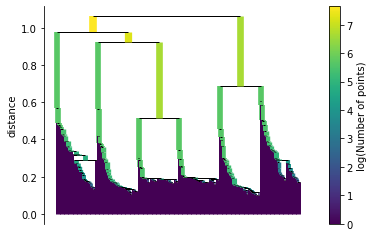

In [45]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True) # dendrogram
plt.show()

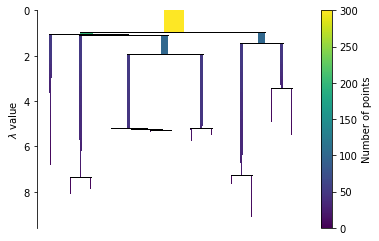

In [46]:
# 일정 distance 미만의 데이터(minimum size 미만의 클러스터)를 noise로 처리
clusterer.condensed_tree_.plot()
plt.show()

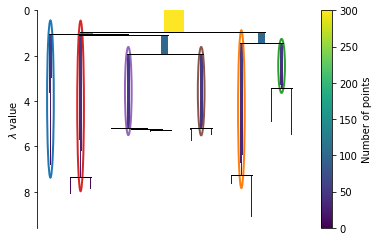

In [47]:
# 안정적인 클러스터 추출 (오래 살아남은 클러스터)
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

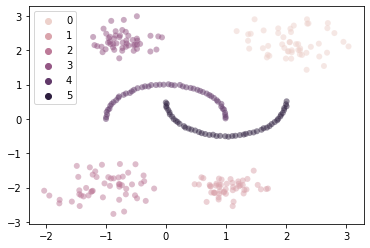

In [48]:
sns.scatterplot(x=test_data.T[0], y=test_data.T[1], hue=clusterer.labels_, linewidth=0, alpha=0.5)
plt.show()

## Non-hierarchical Clustering

### (1) K-Means
- 군집 개수만큼 초기값을 지정하고 초기 군집을 형성한 후, 평균을 재계산하여 값 갱신
- 초기 센트로이드는 K-means++ 알고리즘이 기본값 (random보다 좋음)
- Scaling 필요
- 이상치 영향을 많이 받을 수 있고, 볼록한 군집 형태가 아니면 성능이 떨어짐
- 변수가 많은 경우 정확도가 떨어짐 (PCA 고려)
- 군집 방법
    - Hard: 각 샘플에 대해 가장 가까운 클러스터 선택
    - Soft: 클러스터마다 샘플에 점수 부여하고, 중심과의 유클리드 거리 계산
- Inertia
    - 각 샘플과 가장 가까운 센트로이드 사이의 평균 제곱 거리
    - 랜덤 초기화를 하여 여러 번 알고리즘을 실행한 다음, 이너셔가 낮은 모델을 선택하게 됨

In [49]:
iris = load_iris()
iris = pd.DataFrame(iris.data, columns=iris.feature_names)
iris['Class'] = load_iris().target
iris['Class'] = iris['Class'].map({0: 'Setosa', 1: 'Versicolour', 2: 'Virginica'})

In [50]:
x = iris.drop('Class', axis=1)
x.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [51]:
from sklearn.cluster import KMeans

In [52]:
### elbow plot
def elbow(x):
    sse=[]
    for i in range(1, 11):
        km = KMeans(n_clusters=i, random_state=1)
        km.fit(x)
        sse.append(km.inertia_)
    
    plt.plot(range(1, 11), sse, marker='o')
    plt.xlabel('The Number of Clusters')
    plt.ylabel('SSE')
    plt.show()
    
    print(sse)

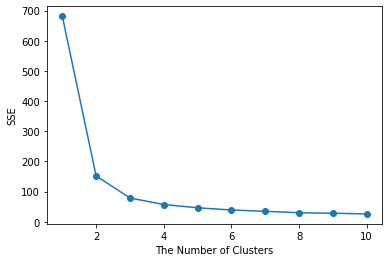

[681.3706, 152.34795176035792, 78.85144142614601, 57.256009315718146, 46.44618205128205, 39.066035353535355, 34.723277629233515, 29.99042640692641, 28.278674715635248, 26.094089542638308]


In [53]:
elbow(x)

In [54]:
from sklearn.metrics import calinski_harabasz_score

In [55]:
# 클러스터별 콜린스키 하라바츠 결과 비교
# 가장 높은 값 선택
for k in range(2, 10):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(x)
    labels = kmeans_model.labels_
    print(calinski_harabasz_score(x, labels))

513.9245459802768
561.62775662962
530.4871420421675
495.54148767768777
473.5154538824768
443.84523107907245
440.59767319067873
407.0468400265113


In [56]:
# 최적의 k로  K-Means 군집화 실행
km = KMeans(n_clusters=3, random_state=1)
km.fit(x)

# 할당된 군집을 iris 데이터에 추가
new_labels = km.labels_
iris['cluster'] = new_labels

iris.drop('Class', axis=1).groupby(['cluster']).mean()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
cluster,,,,
0,5.901613,2.748387,4.393548,1.433871
1,5.006000,3.428000,1.462000,0.246000
2,6.850000,3.073684,5.742105,2.071053


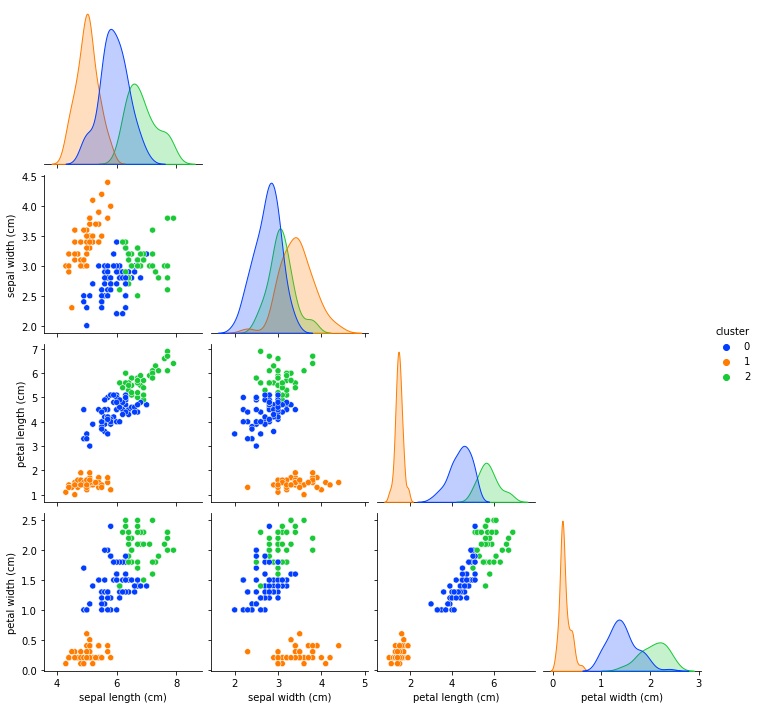

In [57]:
# k-means 시각화 
# 군집결과 시각화
sns.pairplot(iris, diag_kind='kde', hue="cluster", corner=True, palette='bright')
plt.show()


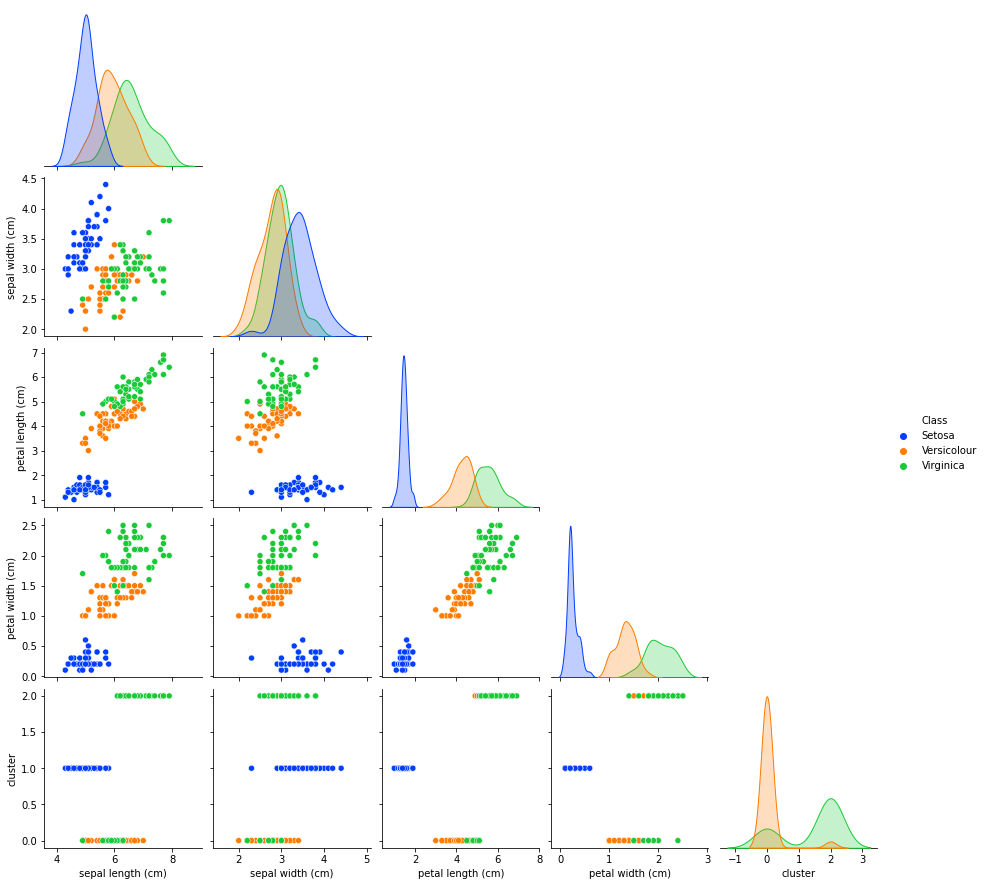

In [58]:
### 원본 class와 비교
sns.pairplot(iris, diag_kind='kde', hue="Class", corner=True, palette='bright')
plt.show()

In [59]:
x, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.8, random_state=0)
print(x.shape, y.shape)

# y target 값의 분포를 확인
unique, counts = np.unique(y, return_counts=True)
print(unique,counts)

(200, 2) (200,)
[0 1 2] [67 67 66]


In [60]:
cluster = pd.DataFrame(data=x, columns=['ftr1', 'ftr2'])
cluster['target'] = y
cluster.head(3)

,ftr1,ftr2,target
0,-1.692427,3.622025,2
1,0.697940,4.428867,0
2,1.100228,4.606317,0


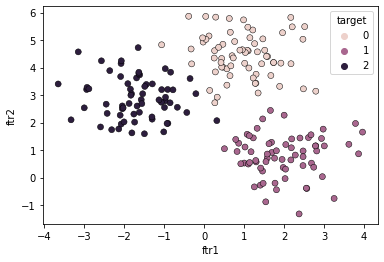

In [61]:
sns.scatterplot(x=cluster['ftr1'], y=cluster['ftr2'], edgecolor='black', hue=cluster['target'])
plt.show()

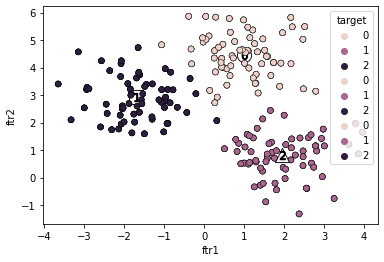

In [62]:
# KMeans 객체를 이용하여 X 데이터를 K-Means 클러스터링 수행 
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=200, random_state=0)
cluster_labels = kmeans.fit_predict(x)
cluster['kmeans_label']  = cluster_labels

#cluster_centers_ 는 개별 클러스터의 중심 위치 좌표 시각화를 위해 추출
centers = kmeans.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'P','D','H','x']

# 군집된 label 유형별로 iteration 하면서 marker 별로 scatter plot 수행. 
for label in unique_labels:
    label_cluster = cluster[cluster['kmeans_label']==label]
    center_x_y = centers[label]
    sns.scatterplot(x=cluster['ftr1'], y=cluster['ftr2'], edgecolor='black', hue=cluster['target'])
    
    # 군집별 중심 위치 좌표 시각화 
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white',
                alpha=0.9, edgecolor='k', marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', 
                marker='$%d$' % label)

plt.show()

In [63]:
print(cluster.groupby('target')['kmeans_label'].value_counts())

target  kmeans_label
0       0               66
        1                1
1       2               67
2       1               65
        2                1
Name: kmeans_label, dtype: int64


In [64]:
### another blobs
blob_centers = np.array([[ 0.2, 2.3], [-1.5, 2.3], [-2.8, 1.8], [-2.8, 2.8], [-2.8, 1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

x, y = make_blobs(n_samples=1000, centers=blob_centers, cluster_std=blob_std, random_state=7)

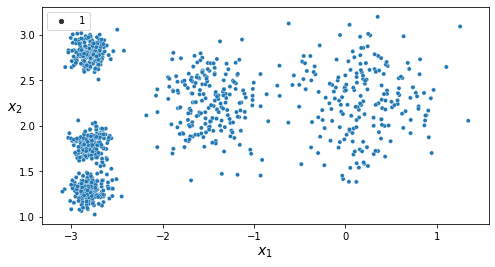

In [65]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x=x[:, 0], y=x[:, 1], size=1)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.show()

In [66]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(x)

# cluster 중심
kmeans.cluster_centers_[:20]

array([[-2.80248802,  2.8023078 ],
       [ 0.20088156,  2.2751718 ],
       [-2.80906999,  1.29323645],
       [-1.47273449,  2.25383102],
       [-2.77986689,  1.79516229]])

In [67]:
# labels
kmeans.labels_[:20]

array([0, 1, 1, 2, 0, 4, 1, 1, 1, 0, 1, 3, 4, 3, 4, 4, 3, 1, 1, 2],
      dtype=int32)

In [68]:
x_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(x_new)

array([1, 1, 0, 0], dtype=int32)

In [69]:
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True, show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), inewidths=1, colors='k')
    sns.scatterplot(x=X[:, 0], y=X[:, 1], color='black', size=2)
    
    if show_centroids:
        centroids = clusterer.cluster_centers_
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=35, linewidths=8, color='w', zorder=10, alpha=0.9)
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=2, linewidths=12, color='k', zorder=11, alpha=1)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
        
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

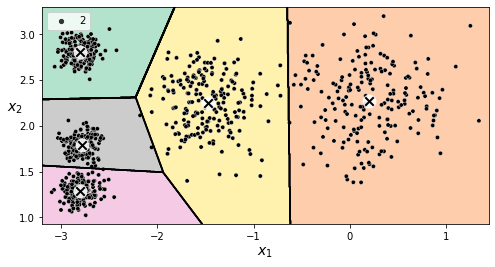

In [70]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, x)
plt.show()

In [71]:
kmeans.transform(x_new)

array([[2.91507065, 0.34069476, 2.8966168 , 1.49444875, 2.78740353],
       [5.85769281, 2.81261152, 5.85190643, 4.47993125, 5.78349546],
       [0.27945159, 3.28192302, 1.7174097 , 1.69979648, 1.22478264],
       [0.36111077, 3.20876775, 1.22177434, 1.54697741, 0.7384137 ]])

In [72]:
# inertia
kmeans.inertia_

104.89322309085537

In [73]:
# score는 음수 출력 (클 수록 좋은 것 규칙)
kmeans.score(x)

-104.89322309085534

In [74]:
# n_init 지정 가능 (default 10)
kmeans_rnd_10_inits = KMeans(n_clusters=5, n_init=10, init="random", algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(x)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

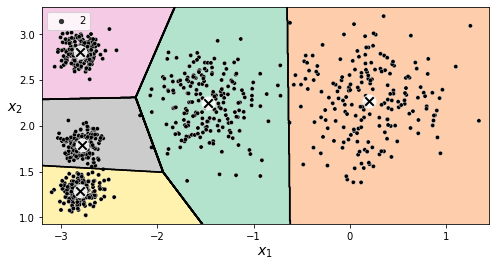

In [75]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, x)
plt.show()

In [76]:
### elkan 알고리즘 (default) 은 더 빠르지만, 희소 행렬은 지원하지 않음
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(x)

74.5 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [77]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(x)

51.7 ms ± 484 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


#### Best K
- Calinski_harabasz: 높을수록 성능이 좋음
- Elbow: SSE가 급격하게 줄거나, 기울기가 소실되는 구간 판단
- Silhouette score, silhouette plot: 샘플 개수 실루엣 계수 종합적으로 판단
    - 각 군집 간의 거리가 얼마나 효율적으로 분리되어 있는지 판단
    - (b-a)/max(a, b). a는 클러스터 내 다른 샘플까지의 평균 거리, b는 가장 가까운 클러스터까지 평균 거리

In [78]:
### elbow plot
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(x) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

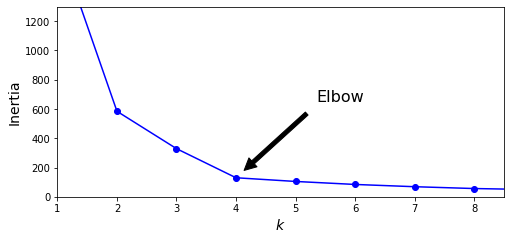

In [79]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow', xy=(4, inertias[3]), xytext=(0.55, 0.55), textcoords='figure fraction', 
             fontsize=16, arrowprops=dict(facecolor='black', shrink=0.1))
plt.axis([1, 8.5, 0, 1300])
plt.show()

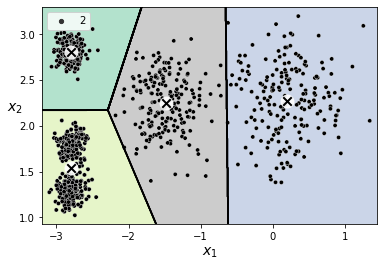

In [80]:
plot_decision_boundaries(kmeans_per_k[4-1], x)
plt.show()

In [81]:
from sklearn.metrics import silhouette_score

In [82]:
### silhouette score
# 전체 평균이 1에 가까울수록 좋음
# 군집의 스코어 편차가 작은 것이 좋음
silhouette_score(x, kmeans.labels_)

0.6591912689661514

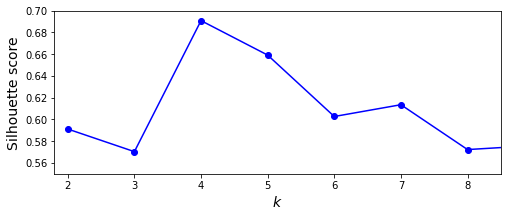

In [83]:
silhouette_scores = [silhouette_score(x, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

In [84]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

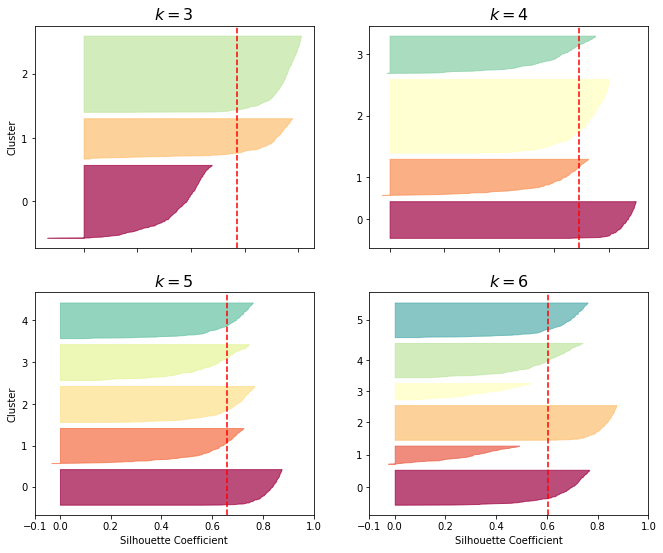

In [85]:
### silhouette diagram
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(x, y_pred)

    padding = len(x) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

In [86]:
iris_result = iris.groupby(['Class', 'cluster'])['sepal length (cm)'].count()
print(iris_result)

Class        cluster
Setosa       1          50
Versicolour  0          48
             2           2
Virginica    0          14
             2          36
Name: sepal length (cm), dtype: int64


In [87]:
x = iris.drop('Class', axis=1)

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(x)

iris['pca_x'] = pca_transformed[:,0]
iris['pca_y'] = pca_transformed[:,1]

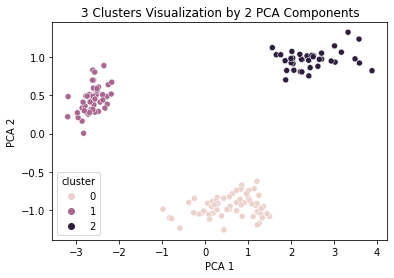

In [88]:
sns.scatterplot(x=iris['pca_x'], y=iris['pca_y'], hue=iris.cluster)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

In [89]:
# iris 의 모든 개별 데이터에 실루엣 계수값을 구함. 
score_samples = silhouette_samples(x.iloc[:, :4], iris['cluster'])
print('silhouette_samples() return 값의 shape' , score_samples.shape)

# irisDF에 실루엣 계수 컬럼 추가
iris['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함. 
average_score = silhouette_score(x.iloc[:, :4], iris['cluster'])
print('붓꽃 데이터셋 Silhouette Analysis Score:{0:.3f}'.format(average_score))

silhouette_samples() return 값의 shape (150,)
붓꽃 데이터셋 Silhouette Analysis Score:0.553


In [90]:
iris.groupby('cluster')['silhouette_coeff'].mean()

cluster
0    0.417320
1    0.798140
2    0.451105
Name: silhouette_coeff, dtype: float64

In [91]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):     
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

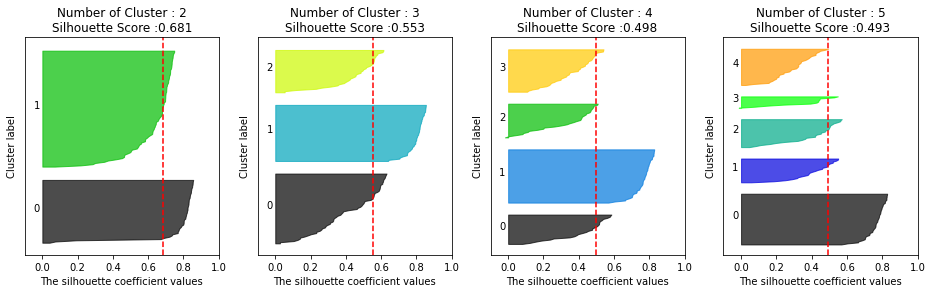

In [92]:
visualize_silhouette([2, 3, 4, 5], x.iloc[:, :4])

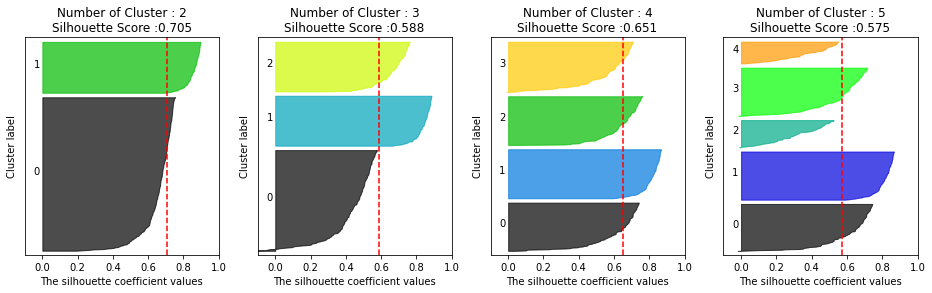

In [93]:
# make_blobs 을 통해 clustering 을 위한 4개의 클러스터 중심의 500개 2차원 데이터 셋 생성  
x, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, center_box=(-10.0, 10.0), shuffle=True, random_state=1)  

# cluster 개수를 2개, 3개, 4개, 5개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([2, 3, 4, 5], x)

In [94]:
# wine data
wine_load = load_wine()
wine = pd.DataFrame(wine_load.data, columns=wine_load.feature_names)
wine['Class'] = wine_load.target
wine['Class'] = wine['Class'].map({0: 'class_0', 1: 'class_1', 2: 'class_2'})
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0


In [95]:
wine['Class'] = np.where(wine['Class']=='class_0', 0, np.where(wine['Class']=='class_1', 1, 2))

In [96]:
x = wine.drop('Class', axis=1)
y = wine['Class']

In [97]:
scaler = StandardScaler()
scaled = scaler.fit_transform(x)
scaled_df = pd.DataFrame(scaled, columns=[x.columns])

In [98]:
# 클러스터별 콜린스키 하라바츠 결과 비교
# 가장 높은 값 선택
for k in range(2, 10):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(scaled)
    labels = kmeans_model.labels_
    print(calinski_harabasz_score(scaled, labels))

69.48646422404195
70.9400080031512
56.17394712859297
46.92280591119328
41.70374736238613
38.12878130797722
35.736913455820364
33.14415210830037


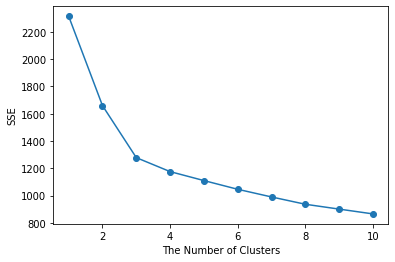

[2314.0000000000005, 1659.0079672511501, 1277.9284888446423, 1175.5045995636674, 1109.8745235738184, 1045.9616347268422, 989.7974824898106, 936.2659545519261, 900.7557350895739, 865.5848462048396]


In [99]:
elbow(scaled)

In [100]:
# 최적의 k로  K-Means 군집화 실행
km = KMeans(n_clusters=3, random_state=1)
km.fit(x)

# 할당된 군집을 데이터에 추가
new_labels = km.labels_
wine['cluster'] = new_labels

wine.groupby(['cluster']).mean()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class
cluster,,,,,,,,,,,,,,
0,13.804468,1.883404,2.426170,17.023404,105.510638,2.867234,3.014255,0.285319,1.910426,5.702553,1.078298,3.114043,1195.148936,0.021277
1,12.516667,2.494203,2.288551,20.823188,92.347826,2.070725,1.758406,0.390145,1.451884,4.086957,0.941159,2.490725,458.231884,1.275362
2,12.929839,2.504032,2.408065,19.890323,103.596774,2.111129,1.584032,0.388387,1.503387,5.650323,0.883968,2.365484,728.338710,1.258065


In [101]:
confusion_matrix(y, wine['cluster'])

array([[46,  0, 13],
       [ 1, 50, 20],
       [ 0, 19, 29]])

#### Cohesion, Separation
- Cohesion(응집도): 클러스터 내의 모든 거리 가중치의 합. 클러스터 내의 객체들이 밀집해있는 정도를 측정함(=SSE, inertia)
- Separation(분리도): 클러스터 외부 객체 간의 모든 거리 가중치의 합으로, 클러스터 간 잘 분리되어 있는 정도를 측정함. 각 클러스터의 중심점과의 pairwise 거리 최소값으로 측정

In [102]:
from sklearn.metrics import pairwise_distances_argmin_min

In [103]:
d = pairwise_distances_argmin_min(km.cluster_centers_, scaled_df)[1]

print(f'군집결과의 응집도는 {round(km.inertia_, 3)}, 분리도는 {round(sum(d) / len(d), 3)}')

군집결과의 응집도는 2370689.687, 분리도는 798.381


#### Minibatch K-means

In [104]:
from sklearn.cluster import MiniBatchKMeans

In [105]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(x)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [106]:
minibatch_kmeans.inertia_

942326.0856517678

In [107]:
### mnist data
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)
x_train, x_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"], random_state=42)

In [108]:
# memmap 사용
filename = "my_mnist.data"
x_mm = np.memmap(filename, dtype='float32', mode='write', shape=x_train.shape)
x_mm[:] = x_train

In [109]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(x_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

In [110]:
# batch load
def load_next_batch(batch_size):
    return x_mm[np.random.choice(len(x_mm), batch_size, replace=False)]

k = 5
n_init = 10
n_iterations = 100
batch_size = 30
init_size = 100  # K-Means++ 초기화를 위해 충분한 데이터 전달
evaluate_on_last_n_iters = 10

best_kmeans = None
np.random.seed(42)
for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    x_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(x_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        x_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(x_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans
        
best_kmeans.score(x_mm)

-151532404736.0

In [111]:
from timeit import timeit

In [112]:
# 시간 비교
times = np.empty((20, 2))
inertias = np.empty((20, 2))
for k in range(1, 21):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 20), end="")
    times[k-1, 0] = timeit("kmeans_.fit(x)", number=3, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(x)", number=3, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

20/20

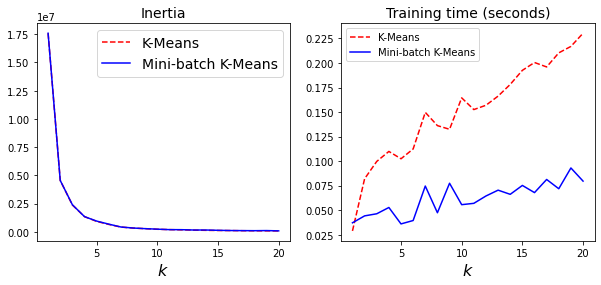

In [113]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
sns.lineplot(x=range(1, 21), y=inertias[:, 0], color="red", linestyle="dashed", label="K-Means")
sns.lineplot(x=range(1, 21), y=inertias[:, 1], color="blue", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(122)
sns.lineplot(x=range(1, 21), y=times[:, 0], color="red", linestyle="dashed", label="K-Means")
sns.lineplot(x=range(1, 21), y=times[:, 1], color="blue", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.show()

#### Applications of K-means
- Preprocessing
- Semi-supervised learning

##### Preprocessing

In [115]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=500, random_state=42)
log_reg.fit(x_train, y_train)

LogisticRegression(max_iter=500, multi_class='ovr', random_state=42)

In [116]:
log_reg.score(x_test, y_test) # 기본 모델 정확도

0.9140571428571429

In [117]:
from sklearn.pipeline import Pipeline

In [118]:
pipeline = Pipeline([("kmeans", KMeans(n_clusters=85, random_state=42)), # K-means 추가
                     ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42))])
pipeline.fit(x_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=85, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [119]:
pipeline.score(x_test, y_test)

0.928

##### Semi-supervised Learning

In [120]:
# base model
n_labeled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(x_train[:n_labeled], y_train[:n_labeled])
log_reg.score(x_test, y_test)

0.5632571428571429

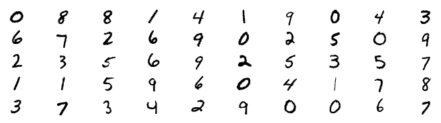

In [121]:
# 대표 이미지 labeling 후 학습
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
x_digits_dist = kmeans.fit_transform(x_train)
representative_digit_idx = np.argmin(x_digits_dist, axis=0)
x_representative_digits = x_train[representative_digit_idx]

plt.figure(figsize=(8, 2))
for index, x_representative_digit in enumerate(x_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(x_representative_digit.reshape(28, 28), cmap="binary", interpolation="bilinear")
    plt.axis('off')
plt.show()

In [122]:
y_train[representative_digit_idx]

array([0, 8, 8, 1, 4, 1, 9, 0, 4, 3, 6, 7, 2, 6, 9, 0, 2, 5, 0, 9, 2, 3,
       5, 6, 9, 2, 5, 3, 5, 7, 1, 1, 5, 9, 6, 0, 4, 1, 7, 8, 3, 7, 3, 4,
       2, 9, 0, 0, 6, 7], dtype=uint8)

In [123]:
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 1, 8, 6,
    3, 1, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

In [124]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=500, random_state=42)
log_reg.fit(x_representative_digits, y_representative_digits)
log_reg.score(x_test, y_test)

0.13434285714285715

In [125]:
# label 전체 전파
y_train_propagated = np.empty(len(x_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [126]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=500, random_state=42)
log_reg.fit(x_train, y_train_propagated)

LogisticRegression(max_iter=500, multi_class='ovr', random_state=42)

In [127]:
log_reg.score(x_test, y_test)

0.15542857142857142

In [128]:
# 센트로이드 근처 75%에 label 전파
percentile_closest = 75

x_cluster_dist = x_digits_dist[np.arange(len(x_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_==i)
    cluster_dist = x_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (x_cluster_dist > cutoff_distance)
    x_cluster_dist[in_cluster & above_cutoff] = -1
    
partially_propagated = (x_cluster_dist!=-1)
x_train_partially_propagated = x_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [129]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=500, random_state=42)
log_reg.fit(x_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=500, multi_class='ovr', random_state=42)

In [130]:
log_reg.score(x_test, y_test)

0.15405714285714286

In [131]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.16160743770162828

### (3) K-medoids
- 평균 대신 중앙값 사용

In [132]:
x = iris.drop(['Class', 'cluster'], axis=1)

In [133]:
# !pip install scikit-learn-extra
# 제공되지 않는 패키지
from sklearn_extra.cluster import KMedoids

In [134]:
kme = KMedoids(n_clusters=3, metric='euclidean', random_state=1)
kme.fit(x)

# 할당된 군집을 iris 데이터에 추가
new_labels = kme.labels_
iris['cluster_kme'] = new_labels

iris.tail(10) # 군집이 조금 다르게 이루어졌음

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class,cluster,pca_x,pca_y,silhouette_coeff,cluster_kme
140,6.7,3.1,5.6,2.4,Virginica,2,2.409934,0.955831,0.570234,2
141,6.9,3.1,5.1,2.3,Virginica,2,2.020536,1.071079,0.410255,2
142,5.8,2.7,5.1,1.9,Virginica,0,1.331812,-1.100325,0.232253,0
143,6.8,3.2,5.9,2.3,Virginica,2,2.658142,0.968012,0.613247,2
144,6.7,3.3,5.7,2.5,Virginica,2,2.514751,1.002454,0.567078,2
145,6.7,3.0,5.2,2.3,Virginica,2,2.041335,0.983809,0.425136,2
146,6.3,2.5,5.0,1.9,Virginica,0,1.443952,-1.046520,0.104171,0
147,6.5,3.0,5.2,2.0,Virginica,2,1.861730,0.950486,0.314930,2
148,6.2,3.4,5.4,2.3,Virginica,2,1.998312,0.979261,0.352454,2
149,5.9,3.0,5.1,1.8,Virginica,0,1.308178,-0.981777,0.185442,0


### (4) Mean Shift
- 중심을 데이터가 모여 있는 밀도가 가장 높은 곳으로 이동시킴
- 데이터의 분포를 이용하여 군집 중심을 찾음
- KDE (Kernel Density Estimation) 이용
    - 적절한 KDE bandwidth(h) 제공이 중요
    - 작을수록 좁고 뾰족한 KDE이며, overfitting 확률이 높음

In [135]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

In [136]:
x, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift= MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(x)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [ 0  1  2  3  4  5  6  7  8  9 10]


In [137]:
meanshift= MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(x)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3]


In [138]:
bandwidth = estimate_bandwidth(x)
print('bandwidth 값:', round(bandwidth,3))

bandwidth 값: 1.754


In [139]:
cluster = pd.DataFrame(data=x, columns=['ftr1', 'ftr2'])
cluster['target'] = y

# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(x)

meanshift= MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(x)
print('cluster labels 유형:',np.unique(cluster_labels))    

cluster labels 유형: [0 1 2]


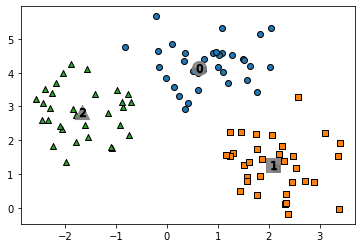

In [140]:
cluster['meanshift_label']  = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = cluster[cluster['meanshift_label']==label]
    center_x_y = centers[label]
    # 군집별로 다른 마커로 산점도 적용
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])
    
    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)
    
plt.show()

In [141]:
print(cluster.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  33
        1                   1
1       1                  33
2       2                  31
        0                   2
Name: meanshift_label, dtype: int64


### (5) Mixture distribution
- 분포 기반 군집분석. 어느 모형(분포)에서 나왔을 확률이 높은지를 계산하며, 통계적으로 엄밀한 결과를 얻을 수 있음
- 일반적으로 타원형 클러스터를 가정 (반달 모양에는 잘 적합되지 않음
- 주로 정규분포를 가정하나, 다른 분포여도 상관없음
- 군집의 크기가 너무 작거나, 가정한 분포와 실제 데이터의 차이가 크면 성능이 떨어짐
- 이상치 처리, scaling 필요
- EM(Expectation-Maximization) Algorithm
    - 초기값 설정
    - 잠재변수 Z의 기대치 계산 (X가 특정 군집에 속할 확률)
    - 기대치를 이용해 파라미터 추정 (계산된 확률로 모수 추정)
    - 반복 정지. Likelihood가 최대가 될 때 수렴함

In [142]:
df = iris.drop(['pca_x', 'pca_y', 'silhouette_coeff'], axis=1)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop('Class', axis=1))

In [143]:
from sklearn.mixture import GaussianMixture

In [144]:
gmm = GaussianMixture(n_components=3)
gmm.fit(df_scaled)
gmm_labels = gmm.predict(df_scaled)
gmm_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0])

In [145]:
df['gmm_cluster'] = gmm_labels

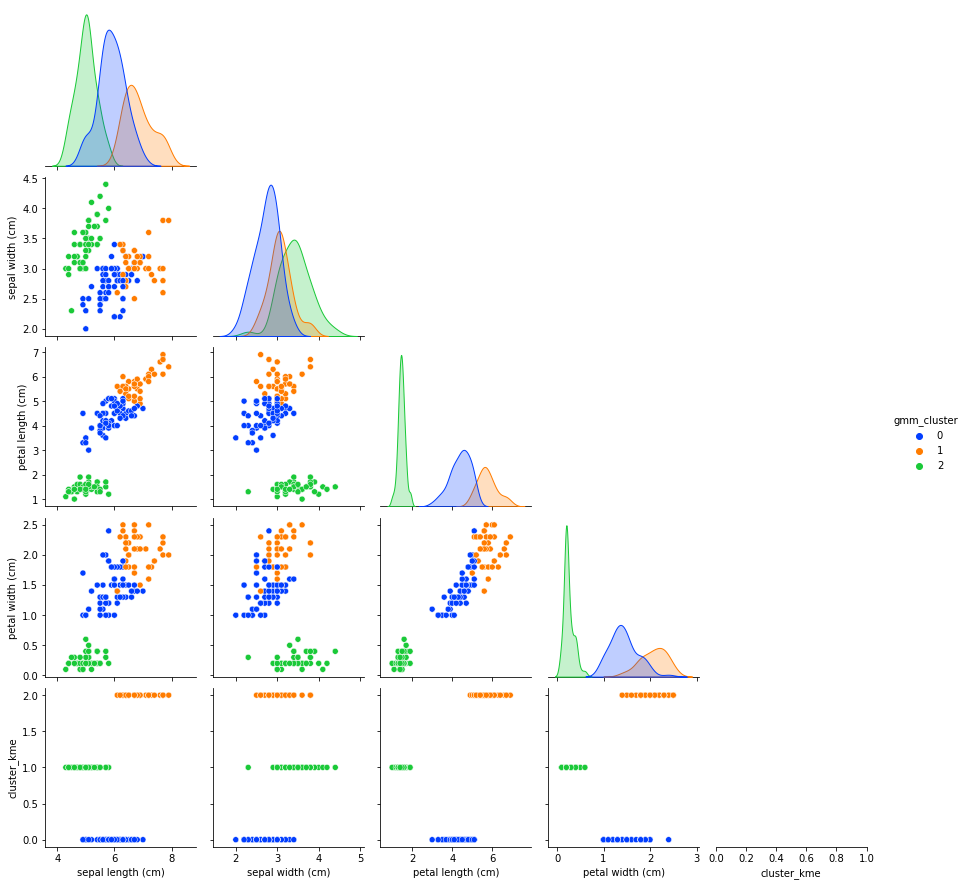

In [146]:
# 군집결과 시각화
sns.pairplot(df.drop('cluster', axis=1), diag_kind='kde', hue="gmm_cluster", corner=True, palette='bright')
plt.show()

In [147]:
# target 값에 따라서 gmm_cluster 값이 어떻게 매핑되었는지 확인. 
iris_result = df.groupby(['Class'])['gmm_cluster'].value_counts()
print(iris_result)

Class        gmm_cluster
Setosa       2              50
Versicolour  0              48
             1               2
Virginica    1              36
             0              14
Name: gmm_cluster, dtype: int64


In [148]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, is_center=True):
    if is_center:
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    is_noise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            is_noise = True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70, edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if is_center:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white', alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)
    if is_noise:
        legend_loc = 'upper center'
    else: legend_loc = 'upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

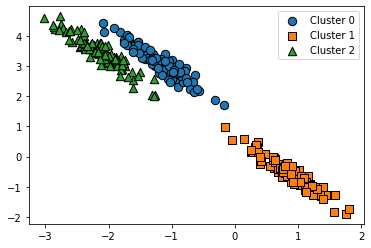

In [149]:
### 길게 늘어난 타원형의 데이터 셋 -> KMeans는 잘 클러스터링 하지 못하는 데이터
# make_blobs() 로 300개의 데이터 셋, 3개의 cluster 셋, cluster_std=0.5 을 만듬. 
x, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 데이터 변환 
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
x_aniso = np.dot(x, transformation)
# feature 데이터 셋과 make_blobs(x) 의 y 결과 값을 DataFrame으로 저장
cluster = pd.DataFrame(data=x_aniso, columns=['ftr1', 'ftr2'])
cluster['target'] = y
# 생성된 데이터 셋을 target 별로 다른 marker 로 표시하여 시각화 함. 
visualize_cluster_plot(None, cluster, 'target', is_center=False)

In [150]:
# 3개의 n_components기반 GMM을 x_aniso 데이터 셋에 적용 
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(x_aniso).predict(x_aniso)
cluster['gmm_label'] = gmm_label

print('\n### Gaussian Mixture Clustering ###')
print(cluster.groupby('target')['gmm_label'].value_counts())


### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: gmm_label, dtype: int64


In [151]:
# faithful data
faithful = pd.read_csv('./r_csv/datasets/faithful.csv', index_col='Unnamed: 0')
faithful.head()

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85


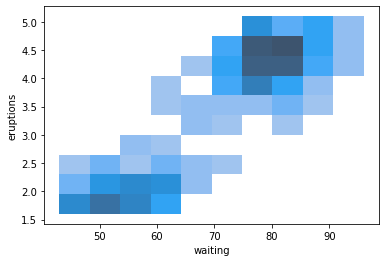

In [152]:
sns.histplot(x='waiting', y='eruptions', data=faithful)
plt.show()

In [153]:
scaler = StandardScaler()
faithful_scaled = scaler.fit_transform(faithful)

gmm = GaussianMixture(n_components=2)
gmm.fit(faithful_scaled)
gmm_labels = gmm.predict(faithful_scaled)
gmm_labels

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1])

In [154]:
faithful['gmm_cluster'] = gmm_labels

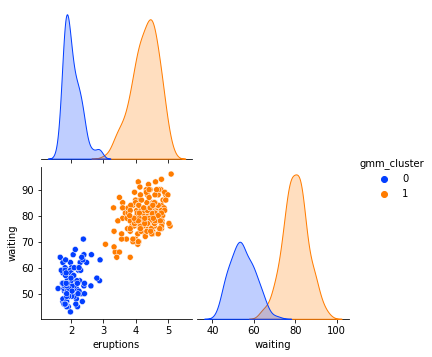

In [155]:
# 군집결과 시각화
sns.pairplot(faithful, diag_kind='kde', hue="gmm_cluster", corner=True, palette='bright')
plt.show()

In [156]:
### mixed blobs
x1, y1 = make_blobs(n_samples=100, centers=((4, -4), (0, 0)), random_state=42)
x1 = x1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))

x2, y2 = make_blobs(n_samples=25, centers=1, random_state=42)
x2 = x2 + [6, -8]
x = np.r_[x1, x2] # array 붙이기
y = np.r_[y1, y2]

In [157]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(x)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [158]:
gm.weights_

array([0.2368444 , 0.39932141, 0.3638342 ])

In [159]:
gm.means_

array([[ 3.03543564,  0.86914847],
       [-1.53583314,  1.23734961],
       [-0.08868617, -0.16945711]])

In [160]:
gm.covariances_

array([[[ 1.0146403 , -0.23275168],
        [-0.23275168,  0.96153326]],

       [[ 0.62196185,  0.68773089],
        [ 0.68773089,  0.98949207]],

       [[ 0.45077719,  0.52738099],
        [ 0.52738099,  0.87891856]]])

In [161]:
# EM 수렴 여부
gm.converged_

True

In [162]:
# 반복 횟수
gm.n_iter_

4

In [163]:
# predict
gm.predict(x)
# gm.predict_proba(x)

array([2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2,
       2, 2, 0, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1,
       2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [164]:
### 생성 모델의 특징
# 군집으로부터 샘플 생성
x_new, y_new = gm.sample(6)
print(x_new, y_new)

[[ 3.38161146  2.33254389]
 [-1.30325812  1.42244585]
 [-1.26539824 -1.49204408]
 [ 0.06338836  0.35687283]
 [ 0.31833122  0.17710092]
 [ 0.25208798 -0.72294966]] [0 1 2 2 2 2]


In [165]:
# PDF 추정
# 점수가 높을수록 밀도가 높음
gm.score_samples(x)

array([-2.03258751, -2.17086215, -3.83024553, -1.87464553, -2.65439074,
       -3.21340998, -1.88825542, -2.00479653, -3.70013238, -3.11569122,
       -1.8017335 , -2.46077275, -2.04730229, -2.14713553, -2.1567461 ,
       -2.75969012, -2.26919459, -3.29028438, -2.62688669, -1.92347127,
       -1.8871611 , -3.82034126, -2.65725966, -2.4852267 , -4.07835149,
       -2.07976823, -2.38125921, -2.79043898, -2.39074995, -3.29481999,
       -2.4716914 , -2.3641291 , -2.39344197, -2.5885198 , -3.25335674,
       -6.85948201, -1.99255213, -3.78256394, -3.11896251, -1.89247477,
       -2.20354285, -3.77759371, -2.15082132, -2.4956231 , -2.39714258,
       -3.23364606, -2.68880912, -4.24574108, -2.1881714 , -2.07733633,
       -2.8192741 , -2.6580395 , -4.35754584, -2.86530234, -3.19491375,
       -3.76411993, -4.31886138, -2.17667128, -1.93630751, -2.48742732,
       -2.23448788, -1.96927835, -3.87220062, -2.77161749, -2.11707028,
       -1.80923132, -4.47427538, -3.17801656, -1.86551829, -3.29

In [166]:
from matplotlib.colors import LogNorm

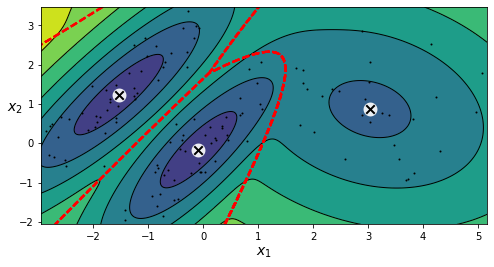

In [167]:
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12), linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    centroids = clusterer.means_[clusterer.weights_ > clusterer.weights_.max() / 10]
    
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=35, linewidths=8, color='w', zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=2, linewidths=12, color='k', zorder=11, alpha=1)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
        
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, x)
plt.show()

##### Covariance types
- full(기본값): 제약이 없습니다. 모든 클러스터가 어떤 크기의 타원도 될 수 있습니다.
- tied: 모든 클러스터가 동일하지만 어떤 타원도 가능합니다(즉, 공분산 행렬을 공유합니다).
- spherical": 모든 클러스터가 원형이지만 지름은 다를 수 있습니다(즉, 분산이 다릅니다).
- diag": 클러스터는 어떤 크기의 타원도 될 수 있지만 타원은 축에 나란해야 합니다(즉, 공분산 행렬이 대각 행렬입니다).

In [168]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)

gm_full.fit(x)
gm_tied.fit(x)
gm_spherical.fit(x)
gm_diag.fit(x)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

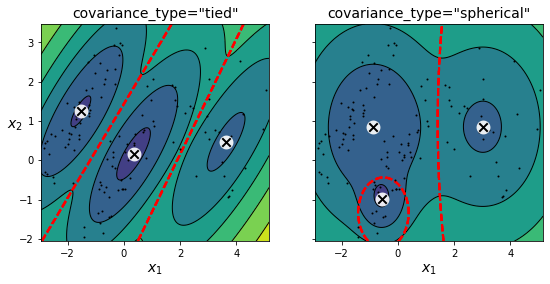

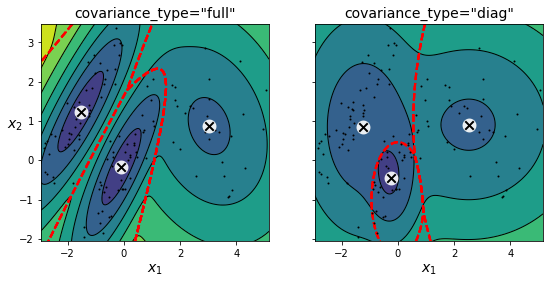

In [169]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_gaussian_mixture(gm_tied, x)
plt.title('covariance_type="{}"'.format(gm_tied.covariance_type), fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(gm_spherical, x, show_ylabels=False)
plt.title('covariance_type="{}"'.format(gm_spherical.covariance_type), fontsize=14)
plt.show()

plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_gaussian_mixture(gm_full, x)
plt.title('covariance_type="{}"'.format(gm_full.covariance_type), fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(gm_diag, x, show_ylabels=False)
plt.title('covariance_type="{}"'.format(gm_diag.covariance_type), fontsize=14)
plt.show()

##### Outlier detection with Gaussian Mixture
- 밀도가 낮은 지역에 있는 샘플을 이상치로 생각할 수 있음
- 사용할 밀도 임곗값을 결정해야 함

In [170]:
densities = gm.score_samples(x)
density_threshold = np.percentile(densities, 4) # 밀도 임계값 정의
anomalies = x[densities < density_threshold]

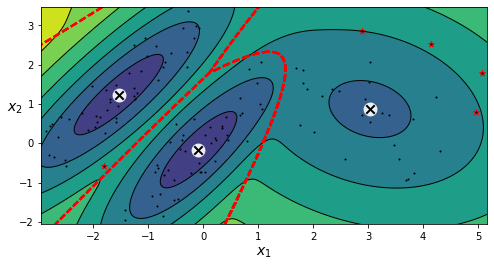

In [171]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, x)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.show()

##### Best K
- BIC, AIC 등 이론적 정보 기준 사용
- 과한 클러스터를 제한하고, 데이터의 잘 맞는 모델을 찾음

In [172]:
gm.bic(x)

853.0276656489054

In [173]:
gm.aic(x)

804.9463321147663

In [174]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(x) for k in range(1, 11)]

In [175]:
bics = [model.bic(x) for model in gms_per_k]
aics = [model.aic(x) for model in gms_per_k]

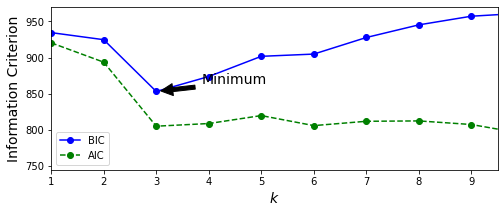

In [176]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

In [177]:
### Best K and covariance type
min_bic = np.infty
for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10, covariance_type=covariance_type, random_state=42).fit(x).bic(x)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [178]:
print(best_k, best_covariance_type)

4 tied


##### Bayesian Gaussian Mixture
- 불필요한 클러스터의 가중치를 0으로 (또는 0에 가깝게) 수렴시킴
- 최적의 클러스터 개수보다 큰 컴포넌트의 개수 지정

In [179]:
from sklearn.mixture import BayesianGaussianMixture

In [180]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(x)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

In [181]:
np.round(bgm.weights_, 2) # 3개의 클러스터 감지

array([0.4 , 0.25, 0.34, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

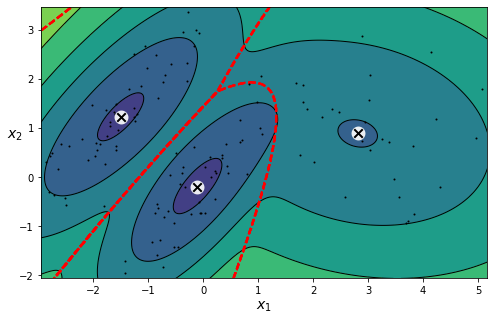

In [182]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, x)
plt.show()

In [183]:
### 클러스터 개수에 대한 사전 믿음(Prior belief) 지정
# weight_concentration_prior
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1, weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1, weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(x[:nn])
bgm_high.fit(x[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

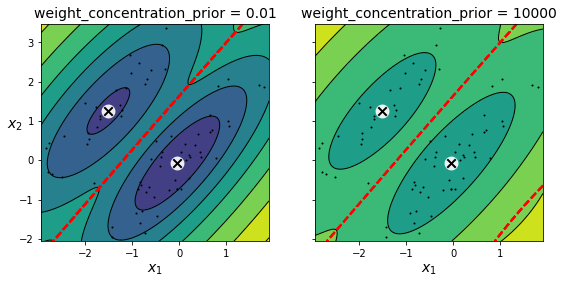

In [184]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, x[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, x[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)
plt.show()

### (6) SOM
- Self-Organizing Maps
- unsupervised NN
- input layer - competitive layer (fully connected). 각 뉴런에서 거리를 구해, 승자 독점 학습

In [185]:
# !pip install minisom
from minisom import MiniSom

In [186]:
wine.reset_index(inplace=True, drop=True)
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class,cluster
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,2


In [187]:
som_data = wine.drop(['Class', 'cluster'], axis=1)
som_target = wine['Class']

# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
som_array = sc.fit_transform(som_data)

In [188]:
n_neurons = 5
m_neurons = 4

som = MiniSom(n_neurons, m_neurons, som_array.shape[1], sigma=1.5, learning_rate=0.5, neighborhood_function='gaussian', random_seed=0)
som.random_weights_init(som_array)
som.train_random(data=som_array, num_iteration=100)

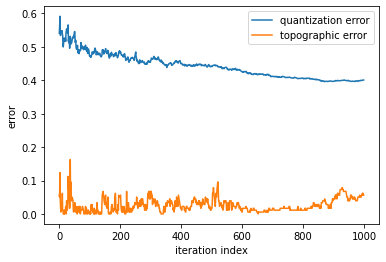

In [189]:
# iter에 따른 Error 시각화
max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(som_array))
    som.update(som_array[rand_i], som.winner(som_array[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(som_array))
    t_error.append(som.topographic_error(som_array))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

In [190]:
som.winner(som_array[0])

(0, 1)

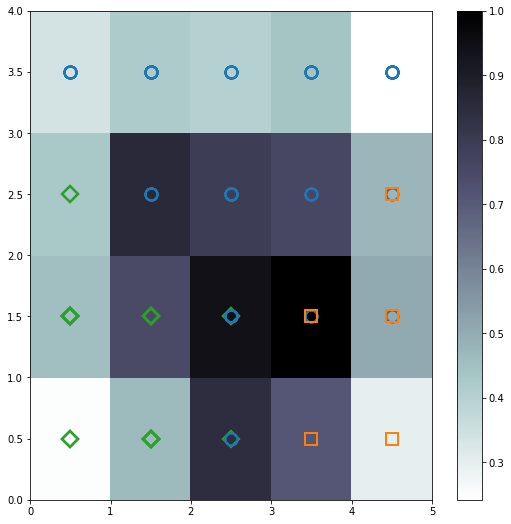

In [191]:
### SOM Visualization
plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's', 'D']
colors = ['C0', 'C1', 'C2']
for cnt, xx in enumerate(som_array):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[som_target[cnt]-1], markerfacecolor='None', 
             markeredgecolor=colors[som_target[cnt]-1], markersize=12, markeredgewidth=2)

plt.show()

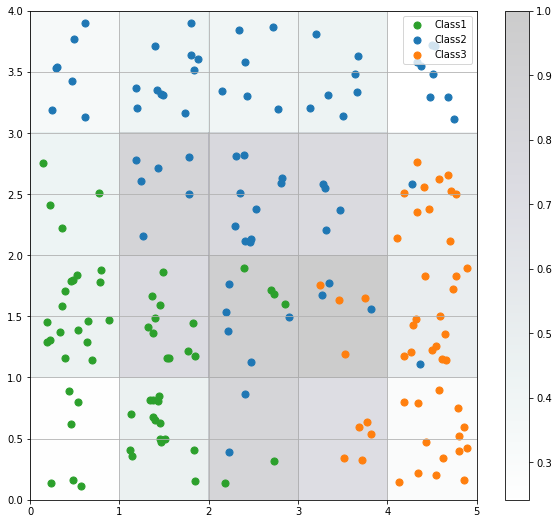

In [192]:
label_names = {0:'Class1', 1:'Class2', 2:'Class3'}

w_x, w_y = zip(*[som.winner(d) for d in som_array])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(som_target):
    idx_target = som_target==c
    plt.scatter(w_x[idx_target] + .5 + (np.random.rand(np.sum(idx_target)) - .5) * .8,
                w_y[idx_target] + .5 + (np.random.rand(np.sum(idx_target)) -.5) *.8, s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

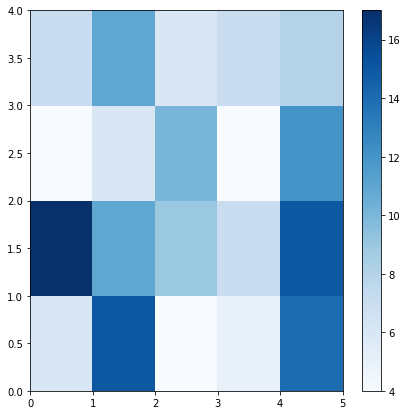

In [193]:
plt.figure(figsize=(7, 7))
frequencies = som.activation_response(som_array)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

In [194]:
import matplotlib.gridspec as gridspec

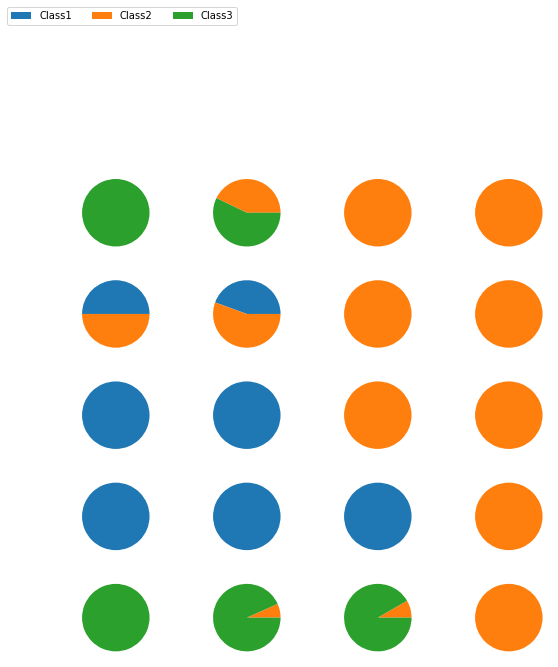

In [195]:
labels_map = som.labels_map(som_array, [label_names[t] for t in som_target.values])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[m_neurons-1-position[0], position[1]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(2, 3), ncol=3)
plt.show()

### (7) DBSCAN
- Density Based Spatial Clusting of Applications with Noise
- 군집 개수를 사전에 결정하지 않는 알고리즘
- 초기 군집 개수를 정해주지 않아도 됨
- 주변 epsilon 거리의 데이터를 군집으로 인식하고, 최소 군집 데이터 수를 정할 수 있음
    - epsilon-이웃
    - epsilon-이웃 안에 min_samples 이상의 샘플이 있다면, core instance (밀집 지역의 샘플)
    - core instance의 이웃은 동일한 클러스터
    - 클러스터에 들어가지 못하면 이상치로 판단 (-1)
- 반달 형태의 군집에 잘 적합
- 새로운 데이터의 군집 예측 불가 (예측이 필요하면 KNN Classifier 사용)

In [196]:
x, y = make_moons(n_samples=100, noise=0.05, random_state=42)

In [197]:
from sklearn.cluster import DBSCAN

In [198]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(x)

DBSCAN(eps=0.05)

In [199]:
dbscan.labels_[:10]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [200]:
dbscan.core_sample_indices_[:10] # 핵심 샘플 index

array([], dtype=int64)

In [201]:
dbscan.components_[:3] # 핵심 샘플

array([], shape=(0, 2), dtype=float64)

In [202]:
np.unique(dbscan.labels_) # -1은 이상치

array([-1])

In [203]:
### 이웃 범위를 넓혀서 클러스터링
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(x)

DBSCAN(eps=0.2)

In [204]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

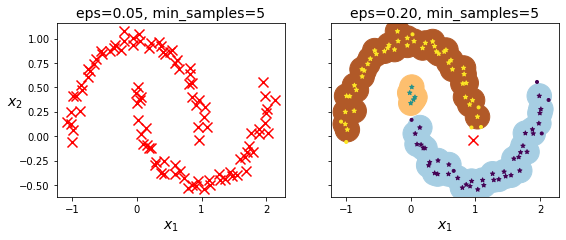

In [205]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, x, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, x, size=600, show_ylabels=False)

plt.show()

In [206]:
from sklearn.neighbors import KNeighborsClassifier

In [207]:
### KNN을 이용한 새 데이터 예측 구현
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [208]:
x_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(x_new)

array([2, 2, 0, 0])

In [209]:
knn.predict_proba(x_new)

array([[0.28, 0.1 , 0.62],
       [0.18, 0.1 , 0.72],
       [0.76, 0.02, 0.22],
       [0.6 , 0.  , 0.4 ]])

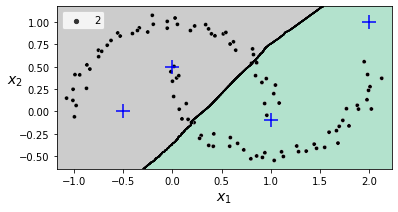

In [210]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, x, show_centroids=False)
plt.scatter(x_new[:, 0], x_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

In [211]:
y_dist, y_pred_idx = knn.kneighbors(x_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan2.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1, -1, -1, -1])

In [212]:
### iris data
feature = iris.iloc[:, :4]
feature.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [213]:
model = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')

In [214]:
predict = pd.DataFrame(model.fit_predict(feature))
predict.columns=['predict']

r = pd.concat([feature, predict],axis=1)
r['target'] = iris.Class
r.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),predict,target
0,5.1,3.5,1.4,0.2,0,Setosa
1,4.9,3.0,1.4,0.2,0,Setosa
2,4.7,3.2,1.3,0.2,0,Setosa
3,4.6,3.1,1.5,0.2,0,Setosa
4,5.0,3.6,1.4,0.2,0,Setosa


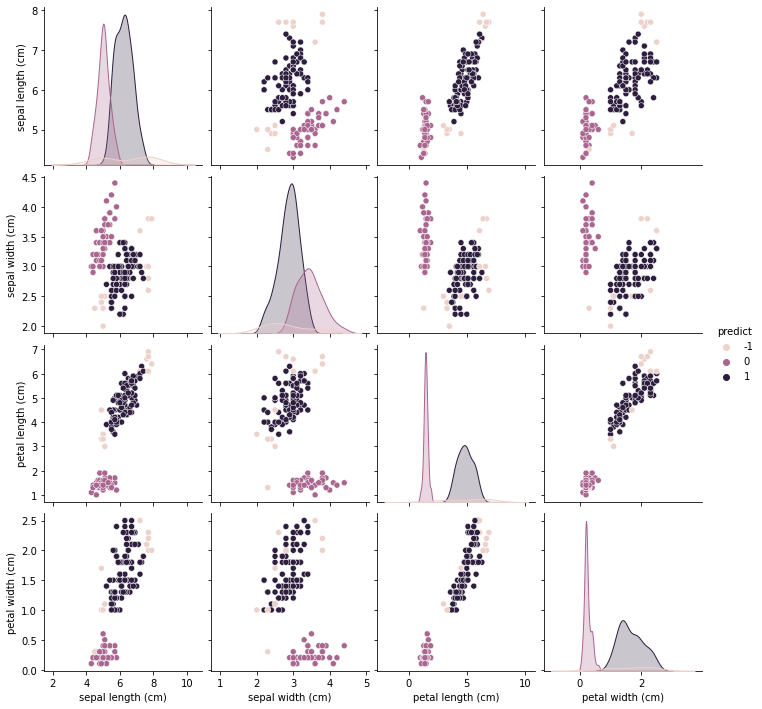

In [215]:
sns.pairplot(r, hue='predict')
plt.show()

In [216]:
iris_result = r.groupby(['target'])['predict'].value_counts()
print(iris_result)

target       predict
Setosa        0         49
             -1          1
Versicolour   1         46
             -1          4
Virginica     1         42
             -1          8
Name: predict, dtype: int64


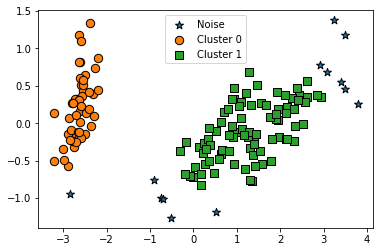

In [217]:
# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(feature)
# visualize_cluster_2d( ) 함수는 ftr1, ftr2 컬럼을 좌표에 표현하므로 PCA 변환값을 해당 컬럼으로 생성
r['ftr1'] = pca_transformed[:,0]
r['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(model, r, 'predict', is_center=False)

target       predict
Setosa        0         50
Versicolour   1         50
Virginica     1         47
             -1          3
Name: predict, dtype: int64


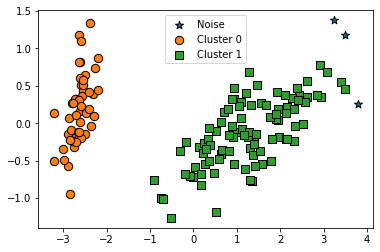

In [218]:
### eps 0.8로 상승 -> noise 감소
dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(feature)

r['predict'] = dbscan_labels
r['target'] = iris.Class

iris_result = r.groupby(['target'])['predict'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, r, 'predict', is_center=False)

target       predict
Setosa        0         48
             -1          2
Versicolour   1         44
             -1          6
Virginica     1         36
             -1         14
Name: predict, dtype: int64


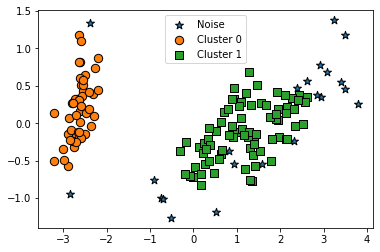

In [219]:
### min_samples 상승 -> noise 증가
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(feature)

r['predict'] = dbscan_labels
r['target'] = iris.Class

iris_result = r.groupby(['target'])['predict'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, r, 'predict', is_center=False)

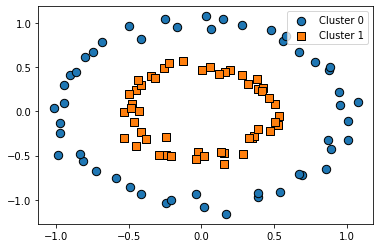

In [220]:
### make_circles dataset
x, y = make_circles(n_samples=100, shuffle=True, noise=0.05, random_state=0, factor=0.5)
cluster = pd.DataFrame(data=x, columns=['ftr1', 'ftr2'])
cluster['target'] = y

visualize_cluster_plot(None, cluster, 'target', is_center=False)

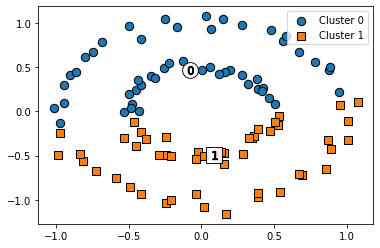

In [221]:
# KMeans로 make_circles( ) 데이터 셋을 클러스터링 수행. 
kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(x)
cluster['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, cluster, 'kmeans_cluster', is_center=True)

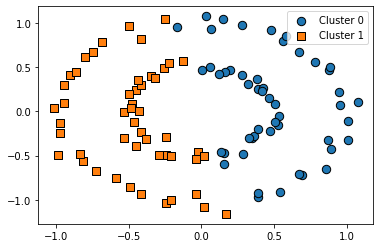

In [222]:
# GMM으로 make_circles() 데이터 셋을 클러스터링 수행. 
gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(x).predict(x)
cluster['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, cluster, 'gmm_cluster', is_center=False)

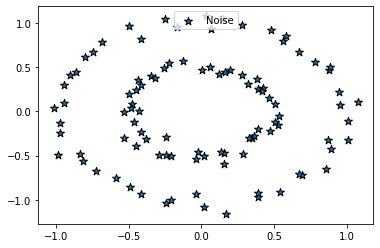

In [223]:
# DBSCAN으로 make_circles( ) 데이터 셋을 클러스터링 수행. 
dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(x)
cluster['dbscan_cluster'] = dbscan_labels

visualize_cluster_plot(dbscan, cluster, 'dbscan_cluster', is_center=False)

In [224]:
### Gower distance 사용
# 범주형 변수가 있는 경우
'''
import gower

distance_matrix = gower.gower_matrix(dataframe)
columns = [f'Customer_{i}' for i in range(1,11)]
distance_matrix = pd.DataFrame(distance_matrix, index=columns, columns=columns)

dbscan_cluster = DBSCAN(eps=0.3, min_samples=2, metric="precomputed")
dbscan_cluster.fit(distance_matrix)

dbscan_cluster.labels_
'''

'\nimport gower\n\ndistance_matrix = gower.gower_matrix(dataframe)\ncolumns = [f\'Customer_{i}\' for i in range(1,11)]\ndistance_matrix = pd.DataFrame(distance_matrix, index=columns, columns=columns)\n\ndbscan_cluster = DBSCAN(eps=0.3, min_samples=2, metric="precomputed")\ndbscan_cluster.fit(distance_matrix)\n\ndbscan_cluster.labels_\n'

### (8) Spectral clustering
- 샘플 사이 유사도 행렬을 받아 저차원 임베딩 (차원축소)
- 저차원 공간에서 군집 알고리즘 사용 (K-means)
- 샘플 개수가 많거나, 클러스터 크기가 다르면 성능 저하

In [225]:
from sklearn.cluster import SpectralClustering

In [226]:
sc1 = SpectralClustering(n_clusters=2, gamma=10, random_state=42)
sc1.fit(x)

sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(x)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [227]:
np.percentile(sc1.affinity_matrix_, 95)

0.6062259936328367

In [228]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

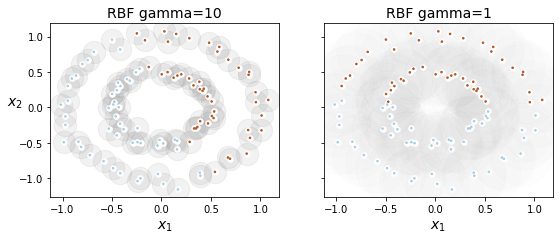

In [229]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, x, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, x, size=4000, alpha=0.01, show_ylabels=False)

plt.show()